### Equations of motion

First, to completely define the rigid bodies, all the information in the previous notebook must be, that is: the mass center points, the reference frames and the inertia. Then, we must declare the effect of gravity in all rigid bodies. 

Also, we must specify the joint torques that will simulate the driving forces acting upon the arm parts.

Finally, we derive the equations of motion of the system using Kane's Method.

---
#### Declaring the rigid bodies

Below, we use the `RigidBody` method to define each rigid body:

In [41]:
from inertial_properties_solution import *
from sympy.physics.mechanics import RigidBody
from IPython.display import Image

In [42]:
# Lower arm rigid body
lower_arm = RigidBody('Lower Arm', lower_arm_mass_center, lower_arm_frame, 
                     lower_arm_mass, lower_arm_central_inertia)

# Upper arm rigid body
upper_arm = RigidBody('Upper Arm', upper_arm_mass_center, upper_arm_frame, 
                     upper_arm_mass, upper_arm_central_inertia)

# Hand rigid body
hand = RigidBody('Hand', hand_mass_center, hand_frame, 
                     hand_mass, hand_central_inertia)

# Finger1 rigid body
finger1 = RigidBody('Finger 1', finger1_mass_center, finger1_frame, 
                     finger1_mass, finger1_central_inertia)

# Finge2 rigid body
finger2 = RigidBody('Finger 2', finger2_mass_center, finger2_frame, 
                     finger2_mass, finger2_central_inertia)

---
#### Gravity effects

First, declare a `symbols` variable, since gravity value is considered to be constant. Then, since forces are bound vectors, i.e. they act on a point, we must associate the force with the mass of each rigid body in the `y` direction of the inertial reference frame.

In [43]:
g = symbols('g')

# Force acting on the lower arm mass center
lower_arm_grav_force_vector = -lower_arm_mass * g * inertial_frame.y

# Force acting on the upper arm mass center
upper_arm_grav_force_vector = -upper_arm_mass * g * inertial_frame.y

# Force acting on the hand mass center
hand_grav_force_vector = -hand_mass * g * inertial_frame.y

# Force acting on the finger 1 mass center
finger1_grav_force_vector = -finger1_mass * g * inertial_frame.y

# Force acting on the finger2 mass center
finger2_grav_force_vector = -finger2_mass * g * inertial_frame.y

# Display gravity forces
lower_arm_grav_force_vector, upper_arm_grav_force_vector,  hand_grav_force_vector, finger1_grav_force_vector, finger2_grav_force_vector

(- g*m_L*I.y, - g*m_U*I.y, - g*m_H*I.y, - g*m_F1*I.y, - g*m_F2*I.y)

Now, we make a tuple to represent the bound vector acting on the mass center of each rigid body:

In [44]:
# Lower arm gravity force tuple
lower_arm_grav_force = (lower_arm_mass_center, lower_arm_grav_force_vector)

# Upper arm gravity force tuple
upper_arm_grav_force = (upper_arm_mass_center, upper_arm_grav_force_vector)

# Hand gravity force tuple
hand_grav_force = (hand_mass_center, hand_grav_force_vector)

# Finger 1 gravity force tuple
finger1_grav_force = (finger1_mass_center, finger1_grav_force_vector)

# Finger 2 gravity force tuple
finger2_grav_force = (finger2_mass_center, finger2_grav_force_vector)

#### Joint torques

As the robot arm movement will be fixed, only the torques acting on the joint will change under different gravity conditions. To satisfy the conditions of the simulation, the torques must be varying with time, which means it must be a `dynamicsymbols` variable.

In [45]:
ground_joint_torque, lower_arm_joint_torque, upper_arm_joint_torque, finger1_joint_torque, finger2_joint_torque = dynamicsymbols('T_g, T_l, T_u, T_f1, T_f2')

# Display the torques
ground_joint_torque, lower_arm_joint_torque, upper_arm_joint_torque, finger1_joint_torque, finger2_joint_torque

(T_g(t), T_l(t), T_u(t), T_h(t), T_f1(t), T_f2(t))

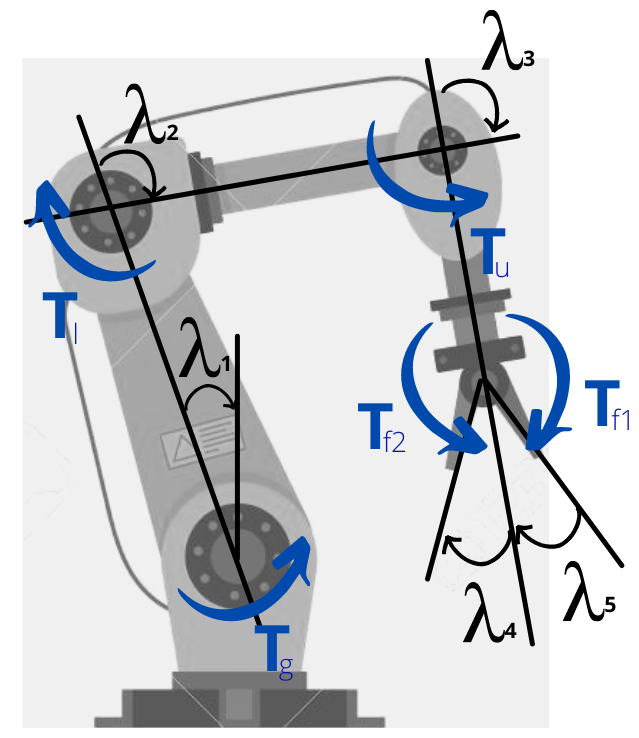

In [46]:
Image('https://user-images.githubusercontent.com/60149913/105992917-0faae000-607c-11eb-9b48-f4344caf0fc1.png', width=350, height=291)

Now, we must specify the reference frame and the direction of all the torques acting on that reference frame. Newton's second law must not be forgotten, we must account all external torques acting upon a body, remembering that the torques acting on the lower arm joint from the upper arm frame is also acting on the lower arm rigid body with oposit force. The lower arm is under the ground joint torque and lower arm joint. The torques orientation will obey the image above.

In [47]:
# Lower arm torques
lower_arm_torque_vector = ground_joint_torque * inertial_frame.z - lower_arm_joint_torque * inertial_frame.z

# Upper arm torques
upper_arm_torque_vector = lower_arm_joint_torque * inertial_frame.z - upper_arm_joint_torque * inertial_frame.z

# Finger 1 torque
finger1_torque_vector = finger1_joint_torque * inertial_frame.z

# Figer 2 torque
finger2_torque_vector = finger2_joint_torque * inertial_frame.z

# Display the torques acting on the rigid bodies
lower_arm_torque_vector, upper_arm_torque_vector, finger1_torque_vector, finger2_torque_vector

((T_g - T_l)*I.z, (T_l - T_u)*I.z, (T_f1 - T_f2 + T_u)*I.z, T_f1*I.z, T_f2*I.z)

Store the torques in a tuple containing the frame and the torque acting on the rigid body

In [48]:
# Lower arm torque tuple
lower_arm_torque = (lower_arm_frame, lower_arm_torque_vector)

# Upper arm torque tuple
upper_arm_torque = (upper_arm_frame, upper_arm_torque_vector)

# Finger 1 torque tuple
finger1_torque = (finger1_frame, finger1_torque_vector)

# Finger 2 torque tuple
finger2_torque = (finger2_frame, finger2_torque_vector)

---
#### Equations of motion

By now, all the necessary components to derive the equations of motion for the system using Kane's Method have already been defined. We will use the `KanesMethod` class, which provides an automated computation of the first order ordinary differential equations given the above quantities. We will also use the `trigsimp` method to reduce expressions by using known trigonometry identities.


In [49]:
from sympy import trigsimp
from sympy.physics.mechanics import KanesMethod

Among the input arguments in `KanesMethod` class, we will use the minimum needed for unconstrained systems: the generalized speeds, kinematical differential equations, the loads, the bodies and a Newtonian reference frame. First, we will need the initial conditions for the angular velocities of the bodies and linear velocities of the points. The ground point's velocity will be setted to zero.

Also, we will create the angular velocities `dynamicsymbols` and enforce the relationship between the generalized coordinates and the angular velocities. Then, we create a list for the coordinates and speeds:

In [50]:
# Creating angular velocities dynamicsymbols
omega1, omega2, omega3, omega4, omega5 = dynamicsymbols('omega1, omega2, omega3, omega4, omega5')

# Expliciting the relationship between the generalized coordinates and the angular velocities
kinematical_differential_equations = [omega1 - lambda1.diff(),
                                      omega2 - lambda2.diff(),
                                      omega3 - lambda3.diff(),
                                      omega4 - lambda4.diff(),
                                      omega5 - lambda5.diff()]

coordinates = [lambda1, lambda2, lambda3, lambda4, lambda5]

speeds = [omega1, omega2, omega3, omega4, omega5]

kinematical_differential_equations

[omega1(t) - Derivative(lambda1(t), t), omega2(t) - Derivative(lambda2(t), t), omega3(t) - Derivative(lambda3(t), t), omega4(t) - Derivative(lambda4(t), t), omega5(t) - Derivative(lambda5(t), t)]

In [51]:
# Linear velocities

# Initial velocity of the ground point is zero
ground_joint.set_vel(inertial_frame, 0) 

# The mass center and joint points linear velocity of the bodies will be calculated upwards through the rigid body two point equation

# Lower arm
lower_arm_mass_center.v2pt_theory(ground_joint, inertial_frame, lower_arm_frame)
lower_arm_mass_center.vel(inertial_frame)

lower_arm_joint.v2pt_theory(ground_joint, inertial_frame, lower_arm_frame)
lower_arm_joint.vel(inertial_frame)

# Upper arm
upper_arm_mass_center.v2pt_theory(lower_arm_joint, inertial_frame, upper_arm_frame)
upper_arm_mass_center.vel(inertial_frame)

upper_arm_joint.v2pt_theory(lower_arm_joint, inertial_frame, upper_arm_frame)
upper_arm_joint.vel(inertial_frame)

# Hand
hand_mass_center.v2pt_theory(upper_arm_joint, inertial_frame, hand_frame)
hand_mass_center.vel(inertial_frame)

hand_joint.v2pt_theory(upper_arm_joint, inertial_frame, hand_frame)
hand_joint.vel(inertial_frame)

# Finger 1
finger1_mass_center.v2pt_theory(hand_joint, inertial_frame, finger1_frame)
finger1_mass_center.vel(inertial_frame)

# Finger 2
finger2_mass_center.v2pt_theory(hand_joint, inertial_frame, finger2_frame)

# Display the velocity of the lower arm and upper arm mass centers with respect to the inertial frame
lower_arm_mass_center.vel(inertial_frame), upper_arm_mass_center.vel(inertial_frame)

(- d_L*omega1*L.x, - l_L*omega1*L.x - d_U*(omega1 + omega2)*U.x)

In [52]:
# Angular velocities
lower_arm_frame.set_ang_vel(inertial_frame, omega1*inertial_frame.z)

upper_arm_frame.set_ang_vel(lower_arm_frame, omega2*inertial_frame.z)

hand_frame.set_ang_vel(upper_arm_frame, omega3*inertial_frame.z)

finger1_frame.set_ang_vel(hand_frame, omega4*inertial_frame.z)

finger2_frame.set_ang_vel(hand_frame, omega5*inertial_frame.z)

# Display bodies angular velocities 
lower_arm_frame.ang_vel_in(inertial_frame), upper_arm_frame.ang_vel_in(inertial_frame), hand_frame.ang_vel_in(inertial_frame), finger1_frame.ang_vel_in(inertial_frame), finger2_frame.ang_vel_in(inertial_frame)

(omega1*I.z, (omega1 + omega2)*I.z, (omega1 + omega2 + omega3)*I.z, (omega1 + omega2 + omega3 + omega4)*I.z, (omega1 + omega2 + omega3 + omega5)*I.z)

In [53]:
# Inputing the KanesMethod, listing the loads and rigid bodies
kane = KanesMethod(inertial_frame, coordinates, speeds, kinematical_differential_equations)

loads = [lower_arm_grav_force,
         upper_arm_grav_force,
         hand_grav_force,
         finger1_grav_force,
         finger2_grav_force, 
         lower_arm_torque,
         upper_arm_torque,
         finger1_torque,
         finger2_torque]
         
bodies = [lower_arm, upper_arm, hand, finger1, finger2]

The equations of motion can be computed using `kanes_equations` method, which takes the lists in the cell above. The method returns the equations of motion in Kane's form, which is Fr+Fr* = 0.

The equations of motion are linear with respect to the derivatives of the generalized speeds. `KanesMethod` class puts the equations in the following form:

- M(x,t)*d(x)/dt=f(x,t)

We must generate the M (mass matrix) and f matrices. The f matrix is a vector function of the non-inertial forces, such as gyroscopic, external, coriolis, etc.). For this, we use the `mass_matrix` and `mass_matrix_full` methods to include the kinematical differential equations. 

In [54]:
# Tip: For 5 generalized coordinates, the matrices below tend to be very complex. Therefore, don't display them unless you need it.
fr, frstar = kane.kanes_equations(bodies, loads)
mass_matrix = trigsimp(kane.mass_matrix_full)
forcing_vector = trigsimp(kane.forcing_full)